In [3]:
# import package
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from wordcloud import WordCloud

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from pprint import pprint

FontPath = 'SourceHanSansTW-Regular.otf'
# fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")

In [4]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示


### 二、資料來源與前處理

* **資料來源：** PTT 八卦版 2024/01/01～2025/05/20，關鍵字 ChatGPT，總計 1154 篇文章。
* **欄位說明：**

  * `artTitle`、`artContent`、`artDate`、`artComment`。

In [5]:
df = pd.read_csv("./raw_data/filtered_data.csv")
df = df[df["artDate"] != "未知"]
df = df[df["artContent"] != " "]
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,Gossiping,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,Gossiping,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt
2,5,https://www.ptt.cc/bbs/Gossiping/M.1704284689....,[問卦]貝佐斯酸ChatGPT?,2024-01-03,arsl400,Gossiping,最近貝佐斯上節目\n說ChatGPT是發現不是發明\n可是我剛剛去問ChatGPT\n它說自...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""bouedx"", ""cm...",219.91.32.112,2024-01-04 01:33:23,ptt
3,7,https://www.ptt.cc/bbs/Gossiping/M.1704326762....,[問卦]AI筆電有啥神應用？,2024-01-04,bebehome,Gossiping,明年是ＡＩ爆發年\n\n各家都推出ＡＩ筆電\n\nＡＩ到底能幹麻？\n\nChatGPT一般...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",125.227.169.174,2024-01-05 01:33:49,ptt
4,8,https://www.ptt.cc/bbs/Gossiping/M.1704332581....,[問卦]訓練阿美語的大型語言模型當碩論可行嗎,2024-01-04,ck960785,Gossiping,以下是chatGPT的生成內容\n\n-\n\n訓練一個專注於特定語言，如阿美語的大型語言模...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""koromo1991"",...",220.138.126.106,2024-01-05 01:34:21,ptt


In [6]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['e_ip']
drop_cols = ['artCatagory']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,是這樣的最近用chat gpt 生產新年賀圖
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,現在是2024了。但是很多人似乎都忘記2023發生什麼事情了。我還記得去年這時候開始準備 缺...
2,5,https://www.ptt.cc/bbs/Gossiping/M.1704284689....,[問卦]貝佐斯酸ChatGPT?,2024-01-03,arsl400,最近貝佐斯上節目\n說ChatGPT是發現不是發明\n可是我剛剛去問ChatGPT\n它說自...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""bouedx"", ""cm...",219.91.32.112,2024-01-04 01:33:23,ptt,最近貝佐斯上節目說ChatGPT是發現不是發明可是我剛剛去問ChatGPT它說自己是發明貝佐...
3,7,https://www.ptt.cc/bbs/Gossiping/M.1704326762....,[問卦]AI筆電有啥神應用？,2024-01-04,bebehome,明年是ＡＩ爆發年\n\n各家都推出ＡＩ筆電\n\nＡＩ到底能幹麻？\n\nChatGPT一般...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",125.227.169.174,2024-01-05 01:33:49,ptt,明年是ＡＩ爆發年。各家都推出ＡＩ筆電。ＡＩ到底能幹麻？。ChatGPT一般電腦就可以用了。Ａ...
4,8,https://www.ptt.cc/bbs/Gossiping/M.1704332581....,[問卦]訓練阿美語的大型語言模型當碩論可行嗎,2024-01-04,ck960785,以下是chatGPT的生成內容\n\n-\n\n訓練一個專注於特定語言，如阿美語的大型語言模...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""koromo1991"",...",220.138.126.106,2024-01-05 01:34:21,ptt,以下是chatGPT的生成內容。-。訓練一個專注於特定語言，如阿美語的大型語言模型，是一項複...


In [7]:
# 先移除空白或 NaN 的欄位
clear_df = clear_df.dropna(subset=['sentence'])
clear_df = clear_df[clear_df['sentence'].str.strip() != '']

# 再做斷句
clear_df['sentence'] = clear_df['sentence'].str.split(r"[,，。！!？?]+")

# 展開為每句一列
sent_df = clear_df.explode('sentence').reset_index(drop=True)

# 去除斷句後的空字串（有時可能會分出空句）
sent_df = sent_df[sent_df['sentence'].str.strip() != '']

sent_df.head()


,system_id,artUrl,artTitle,artDate,artPoster,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,是這樣的最近用chat gpt 生產新年賀圖
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,現在是2024了
2,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,但是很多人似乎都忘記2023發生什麼事情了
3,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,我還記得去年這時候開始準備 缺蛋
4,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,chatgpt大爆發


In [8]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/stop_words.txt')

Building prefix dict from c:\Users\1218a\OneDrive\桌面\大三\社群媒體分析\final\dict\dict.txt ...
Loading model from cache C:\Users\1218a\AppData\Local\Temp\jieba.u059f3dc2e782518fa9c2374aec474732.cache
Loading model cost 0.430 seconds.
Prefix dict has been built successfully.


In [9]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,是這樣的最近用chat gpt 生產新年賀圖
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,現在是2024了
2,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,但是很多人似乎都忘記2023發生什麼事情了
3,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,我還記得去年這時候開始準備 缺蛋
4,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,nk11208z,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt,chatgpt大爆發


In [10]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artContent,artComment,e_ip,insertedDate,dataSource,word
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,這樣
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,最近
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,chat
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,gpt
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,twnndnpdnc,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt,生產


### 三、Lexicon-based 情緒分析

In [11]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [12]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

In [13]:
ptt_liwc_df = pd.merge(word_df[["system_id", "artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

,system_id,artUrl,artDate,artTitle,artContent,word,sentiments
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,這樣,NaN
1,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,最近,NaN
2,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,chat,NaN
3,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,gpt,NaN
4,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,生產,NaN


In [14]:
# word_count = ptt_liwc_df.groupby(["word"]).size().reset_index()
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(20)

,word,sentiments,size
365,可以,positive,647
364,可以,affect,647
436,問題,negative,499
435,問題,affect,499
236,八卦,negative,173
235,八卦,affect,173
1050,支持,affect,150
1051,支持,positive,150
602,安全,affect,122
603,安全,positive,122


In [15]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
365,可以,positive,647
1051,支持,positive,150
603,安全,positive,122
1899,重要,positive,108
673,希望,positive,90
1750,解決,positive,88
1679,自由,positive,87
1867,遊戲,positive,81
1574,簡單,positive,78
1145,朋友,positive,73


In [16]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
436,問題,negative,499
236,八卦,negative,173
1007,控制,negative,104
1969,風險,negative,104
57,不要,negative,96
909,戰爭,negative,90
829,情緒,negative,84
479,嚴重,negative,78
509,壓力,negative,60
1904,錯誤,negative,59


In [17]:
# 設定要移除的字詞列表
words_to_remove = ['問題','打擊','攻擊','打敗', '瘋狂']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df = pd.merge(word_df[["system_id","artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df.head()

,system_id,artUrl,artDate,artTitle,artContent,word,sentiments
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,這樣,NaN
1,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,最近,NaN
2,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,chat,NaN
3,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,gpt,NaN
4,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,2024-01-01,[問卦]這張新年賀圖大家喜歡嗎？,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,生產,NaN


#### 計算sentiment-value
sentiment-value = positive - negative

In [18]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

#正負向情緒分數
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# 計算sentiment
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2024-01-02,1.0,0.0,-1.0
1,2024-01-04,2.0,13.0,11.0
2,2024-01-09,12.0,14.0,2.0
3,2024-01-10,0.0,2.0,2.0
4,2024-01-12,7.0,4.0,-3.0


#### 文章情緒分析

In [19]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artTitle", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artTitle,sentiments,size
0,ChatGPT連房貸都算不出來？,affect,3
1,ChatGPT連房貸都算不出來？,negative,2
2,ChatGPT連房貸都算不出來？,positive,1
3,ChatGPT連房貸都算不出來？,sad,1
4,Fw:[問題]日本best1旅行社未確認取消已付款問題,affect,44
5,Fw:[問題]日本best1旅行社未確認取消已付款問題,anger,2
6,Fw:[問題]日本best1旅行社未確認取消已付款問題,negative,10
7,Fw:[問題]日本best1旅行社未確認取消已付款問題,positive,34
8,Fw:[問題]日本best1旅行社未確認取消已付款問題,sad,3
9,Re:[問卦]188錯在哪？,affect,2


In [20]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artTitle", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artTitle,affect,anger,anx,negative,positive,sad
0,ChatGPT連房貸都算不出來？,3.0,0.0,0.0,2.0,1.0,1.0
1,Fw:[問題]日本best1旅行社未確認取消已付款問題,44.0,2.0,0.0,10.0,34.0,3.0
2,Re:[問卦]188錯在哪？,2.0,1.0,0.0,1.0,1.0,0.0
3,Re:[問卦]484在我們有生之年一定能看到AI有意識？,28.0,2.0,0.0,10.0,14.0,2.0
4,Re:[問卦]AI也太聰明了吧,1.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artTitle,affect,anger,anx,negative,positive,sad,sentiment_value
0,ChatGPT連房貸都算不出來？,3.0,0.0,0.0,2.0,1.0,1.0,-1.0
1,Fw:[問題]日本best1旅行社未確認取消已付款問題,44.0,2.0,0.0,10.0,34.0,3.0,24.0
2,Re:[問卦]188錯在哪？,2.0,1.0,0.0,1.0,1.0,0.0,0.0
3,Re:[問卦]484在我們有生之年一定能看到AI有意識？,28.0,2.0,0.0,10.0,14.0,2.0,4.0
4,Re:[問卦]AI也太聰明了吧,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [22]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

,artTitle,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,ChatGPT連房貸都算不出來？,3.0,0.0,0.0,2.0,1.0,1.0,-1.0,負向
1,Fw:[問題]日本best1旅行社未確認取消已付款問題,44.0,2.0,0.0,10.0,34.0,3.0,24.0,正向
2,Re:[問卦]188錯在哪？,2.0,1.0,0.0,1.0,1.0,0.0,0.0,負向
3,Re:[問卦]484在我們有生之年一定能看到AI有意識？,28.0,2.0,0.0,10.0,14.0,2.0,4.0,正向
4,Re:[問卦]AI也太聰明了吧,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
5,Re:[問卦]AI到底在哪裡沒看到,11.0,1.0,0.0,4.0,6.0,0.0,2.0,正向
6,Re:[問卦]AI即將取代工程師,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
7,Re:[問卦]AI是不是準備要泡沫了,3.0,0.0,0.0,0.0,2.0,0.0,2.0,正向
8,Re:[問卦]AI會讓音樂人失業嗎？,3.0,0.0,0.0,1.0,3.0,0.0,2.0,正向
9,Re:[問卦]AI產生意識並且洗腦控制人類行為怎解？,5.0,0.0,1.0,3.0,2.0,0.0,-1.0,負向


In [23]:
# 合併文章情緒結果回原始文章表（用 artUrl 對應）
final_df = pd.merge(
    df,
    ptt_sentiment_value_by_article[['artTitle', 'sentiment_value', 'sentiment_class']],
    on='artTitle',
    how='left'
)

# 選擇要輸出的欄位
final_output = final_df[['system_id', 'artUrl', 'artTitle', 'artDate', 'artContent', 'artCatagory', 'sentiment_value', 'sentiment_class']]
final_output


,system_id,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_value,sentiment_class
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,Gossiping,NaN,NaN
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,Gossiping,-1.0,負向
2,5,https://www.ptt.cc/bbs/Gossiping/M.1704284689....,[問卦]貝佐斯酸ChatGPT?,2024-01-03,最近貝佐斯上節目\n說ChatGPT是發現不是發明\n可是我剛剛去問ChatGPT\n它說自...,Gossiping,NaN,NaN
3,7,https://www.ptt.cc/bbs/Gossiping/M.1704326762....,[問卦]AI筆電有啥神應用？,2024-01-04,明年是ＡＩ爆發年\n\n各家都推出ＡＩ筆電\n\nＡＩ到底能幹麻？\n\nChatGPT一般...,Gossiping,4.0,正向
4,8,https://www.ptt.cc/bbs/Gossiping/M.1704332581....,[問卦]訓練阿美語的大型語言模型當碩論可行嗎,2024-01-04,以下是chatGPT的生成內容\n\n-\n\n訓練一個專注於特定語言，如阿美語的大型語言模...,Gossiping,7.0,正向
...,...,...,...,...,...,...,...,...
1149,1450,https://www.ptt.cc/bbs/Gossiping/M.1748009653....,Re:[問卦]CHATGPT是不是養套殺,2025-05-23,是 真的越來越覺得AI養套殺很可怕\n\n我前幾天傳素顏照問它最近季節產生的皮膚問題\n\...,Gossiping,2.0,正向
1150,1451,https://www.ptt.cc/bbs/Gossiping/M.1748011072....,Re:[問卦]CHATGPT是不是養套殺,2025-05-23,現在做表格已經很擅長\n\n大概唯一的不行就是\n\n生成圖片太慢\n\n做投影片沒辦法\n...,Gossiping,2.0,正向
1151,1452,https://www.ptt.cc/bbs/Gossiping/M.1748057569....,[問卦]高雄發的電夠高雄用嗎,2025-05-24,Chatgpt\n\n整體來說，高雄發的電「遠遠超過」高雄本地用電需求，是台灣的電力輸出大縣...,Gossiping,-3.0,負向
1152,1453,https://www.ptt.cc/bbs/Gossiping/M.1748060474....,[問卦]ChatGPT小參謀疑似叛變怎麼辦？,2025-05-24,欸欸肥宅\n\n小妹我台大IU\nhttps://i.imgur.com/OCSrYBu.j...,Gossiping,NaN,NaN


In [24]:
final_output = final_output.dropna(subset=['sentiment_class'])
final_output

,system_id,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_value,sentiment_class
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,Gossiping,-1.0,負向
3,7,https://www.ptt.cc/bbs/Gossiping/M.1704326762....,[問卦]AI筆電有啥神應用？,2024-01-04,明年是ＡＩ爆發年\n\n各家都推出ＡＩ筆電\n\nＡＩ到底能幹麻？\n\nChatGPT一般...,Gossiping,4.0,正向
4,8,https://www.ptt.cc/bbs/Gossiping/M.1704332581....,[問卦]訓練阿美語的大型語言模型當碩論可行嗎,2024-01-04,以下是chatGPT的生成內容\n\n-\n\n訓練一個專注於特定語言，如阿美語的大型語言模...,Gossiping,7.0,正向
6,12,https://www.ptt.cc/bbs/Gossiping/M.1704783743....,[問卦]到現在還沒有玩過Chatgpt的，都是怎樣的,2024-01-09,AI發展在這幾年可以說是指數增長，\n台灣作為一個高科技資訊產業國家也很注重這塊的發展。\n...,Gossiping,1.0,正向
7,13,https://www.ptt.cc/bbs/Gossiping/M.1704789944....,[問卦]我們可以從放羊的孩子寓言中學到啥?,2024-01-09,如題\n\n根據CHATGPT\n\n「放羊的孩子」是一個經典的寓言故事，通常用來傳達一些道...,Gossiping,1.0,正向
...,...,...,...,...,...,...,...,...
1148,1449,https://www.ptt.cc/bbs/Gossiping/M.1747986578....,[問卦]為什麼ChatGPT說日本和台灣能源結構相似,2025-05-23,台灣什麼都喜歡學日本，\n所以，剛剛好奇地問了ChatGPT\n台灣和日本的能源結構差異之處...,Gossiping,0.0,負向
1149,1450,https://www.ptt.cc/bbs/Gossiping/M.1748009653....,Re:[問卦]CHATGPT是不是養套殺,2025-05-23,是 真的越來越覺得AI養套殺很可怕\n\n我前幾天傳素顏照問它最近季節產生的皮膚問題\n\...,Gossiping,2.0,正向
1150,1451,https://www.ptt.cc/bbs/Gossiping/M.1748011072....,Re:[問卦]CHATGPT是不是養套殺,2025-05-23,現在做表格已經很擅長\n\n大概唯一的不行就是\n\n生成圖片太慢\n\n做投影片沒辦法\n...,Gossiping,2.0,正向
1151,1452,https://www.ptt.cc/bbs/Gossiping/M.1748057569....,[問卦]高雄發的電夠高雄用嗎,2025-05-24,Chatgpt\n\n整體來說，高雄發的電「遠遠超過」高雄本地用電需求，是台灣的電力輸出大縣...,Gossiping,-3.0,負向


In [25]:
# 儲存為 CSV
final_output.to_csv("raw_data/ptt_chatgpt_sentiment.csv", index=False, encoding='utf-8-sig')
print("✅ 已儲存完整檔案：ptt_chatgpt_sentiment.csv")

✅ 已儲存完整檔案：ptt_chatgpt_sentiment.csv


### 四、討論熱度與情緒時間變化

#### 4.1 討論熱度變化

* 統計每週或每月的文章數，視覺化貼文趨勢。


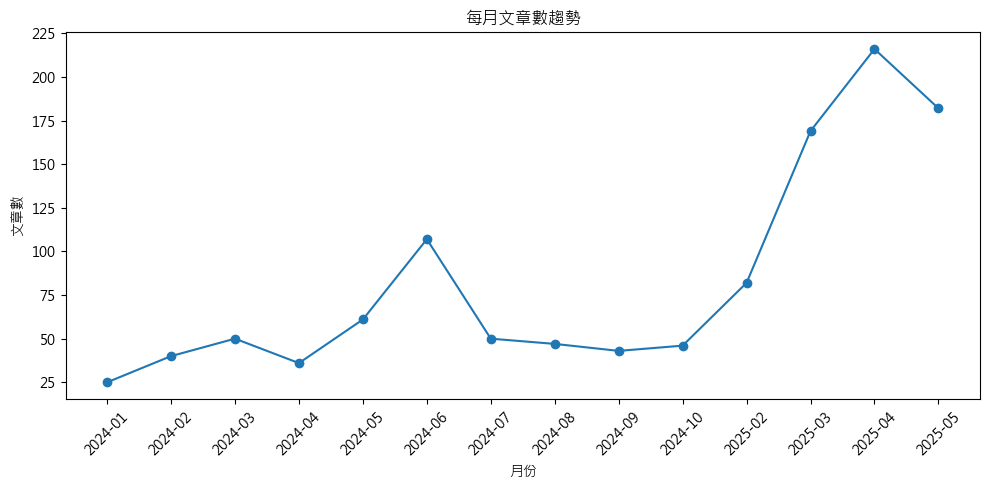

In [26]:
# 統計每月的文章數
df['artDate'] = pd.to_datetime(df['artDate'])
df['artMonth'] = df['artDate'].dt.to_period('M')
monthly_counts = df.groupby('artMonth').size().reset_index(name='post_count')

# 視覺化貼文趨勢
plt.figure(figsize=(10, 5))
plt.plot(monthly_counts['artMonth'].astype(str), monthly_counts['post_count'], marker='o')
plt.title('每月文章數趨勢')
plt.xlabel('月份')
plt.ylabel('文章數')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

這張圖是從 2024 年初到 2025 年 5 月之間，八卦版上有關ChatGPT 的月發文量變化。
可以看到自 2025 年 3 月起發文數大幅上升，4 月達到高峰，我們推測可能與當時全球面臨川普政府發布的新關稅政策、以及所衍伸出的股災有關。因此我們選擇以「2025 年 4 月」作為情緒與熱度分析重點時段。


In [31]:
# 讀取 CSV 檔案
sent_df = pd.read_csv("raw_data/ptt_chatgpt_sentiment.csv")
sent_df

,system_id,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_value,sentiment_class
0,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,Gossiping,-1.0,負向
1,7,https://www.ptt.cc/bbs/Gossiping/M.1704326762....,[問卦]AI筆電有啥神應用？,2024-01-04,明年是ＡＩ爆發年\n\n各家都推出ＡＩ筆電\n\nＡＩ到底能幹麻？\n\nChatGPT一般...,Gossiping,4.0,正向
2,8,https://www.ptt.cc/bbs/Gossiping/M.1704332581....,[問卦]訓練阿美語的大型語言模型當碩論可行嗎,2024-01-04,以下是chatGPT的生成內容\n\n-\n\n訓練一個專注於特定語言，如阿美語的大型語言模...,Gossiping,7.0,正向
3,12,https://www.ptt.cc/bbs/Gossiping/M.1704783743....,[問卦]到現在還沒有玩過Chatgpt的，都是怎樣的,2024-01-09,AI發展在這幾年可以說是指數增長，\n台灣作為一個高科技資訊產業國家也很注重這塊的發展。\n...,Gossiping,1.0,正向
4,13,https://www.ptt.cc/bbs/Gossiping/M.1704789944....,[問卦]我們可以從放羊的孩子寓言中學到啥?,2024-01-09,如題\n\n根據CHATGPT\n\n「放羊的孩子」是一個經典的寓言故事，通常用來傳達一些道...,Gossiping,1.0,正向
...,...,...,...,...,...,...,...,...
955,1449,https://www.ptt.cc/bbs/Gossiping/M.1747986578....,[問卦]為什麼ChatGPT說日本和台灣能源結構相似,2025-05-23,台灣什麼都喜歡學日本，\n所以，剛剛好奇地問了ChatGPT\n台灣和日本的能源結構差異之處...,Gossiping,0.0,負向
956,1450,https://www.ptt.cc/bbs/Gossiping/M.1748009653....,Re:[問卦]CHATGPT是不是養套殺,2025-05-23,是 真的越來越覺得AI養套殺很可怕\n\n我前幾天傳素顏照問它最近季節產生的皮膚問題\n\...,Gossiping,2.0,正向
957,1451,https://www.ptt.cc/bbs/Gossiping/M.1748011072....,Re:[問卦]CHATGPT是不是養套殺,2025-05-23,現在做表格已經很擅長\n\n大概唯一的不行就是\n\n生成圖片太慢\n\n做投影片沒辦法\n...,Gossiping,2.0,正向
958,1452,https://www.ptt.cc/bbs/Gossiping/M.1748057569....,[問卦]高雄發的電夠高雄用嗎,2025-05-24,Chatgpt\n\n整體來說，高雄發的電「遠遠超過」高雄本地用電需求，是台灣的電力輸出大縣...,Gossiping,-3.0,負向


2025年四月的文章數激增，因此以2025四月的文章作為分析對象

#### 4.2 原文情緒時間趨勢

* 對 `artContent` 做情緒分析，畫出四月每週平均情緒分數變化折線圖。



In [69]:
art_sent = pd.read_csv("raw_data\ptt_chatgpt_sentiment.csv")
art_sent['artDate'] = pd.to_datetime(art_sent['artDate'])

april_df = art_sent[
    (art_sent['artDate'].dt.year == 2025) &
    (art_sent['artDate'].dt.month == 4)
].copy()
april_df.head()


,system_id,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_value,sentiment_class
626,984,https://www.ptt.cc/bbs/Gossiping/M.1743437522....,[問卦]閩南生活縮影像吉普力哪部電影？,2025-04-01,把臺灣閩南精神的從小到大的生活點滴\n\n都請ChatGPT轉成吉普力照後\n\n大概都會像...,Gossiping,-2.0,負向
627,986,https://www.ptt.cc/bbs/Gossiping/M.1743468992....,[問卦]欸chatgptdeepseek誰比較鄉民？,2025-04-01,我ㄈㄓ啦\n\n最近工作遇到一些人事狀況，有點苦惱...\n\n明知道小主管就是會得罪一些人...,Gossiping,0.0,負向
628,988,https://www.ptt.cc/bbs/Gossiping/M.1743473347....,[問卦]ChatGPT吉卜力一直失敗欸,2025-04-01,如題\n\n想跟風玩結果一張都沒成功\n\n現在到底要下什麼魔咒\n\n急急急 免費仔今日額...,Gossiping,2.0,正向
629,989,https://www.ptt.cc/bbs/Gossiping/M.1743474843....,[問卦]還有人可以用Chatgpt生圖嗎？,2025-04-01,從昨天下午開始\n只要圖片裡有人臉\n甚至是動物\n都說觸發內容政策限制\n一律無法成功轉換...,Gossiping,4.0,正向
630,990,https://www.ptt.cc/bbs/Gossiping/M.1743480086....,[問卦]ChatGPT要怎麼轉吉卜力風格,2025-04-01,ChatGPT 要怎麼轉吉卜力風格\n\nChatGPT都直接拒絕我\n\n個人貼圖在 PT...,Gossiping,-3.0,負向


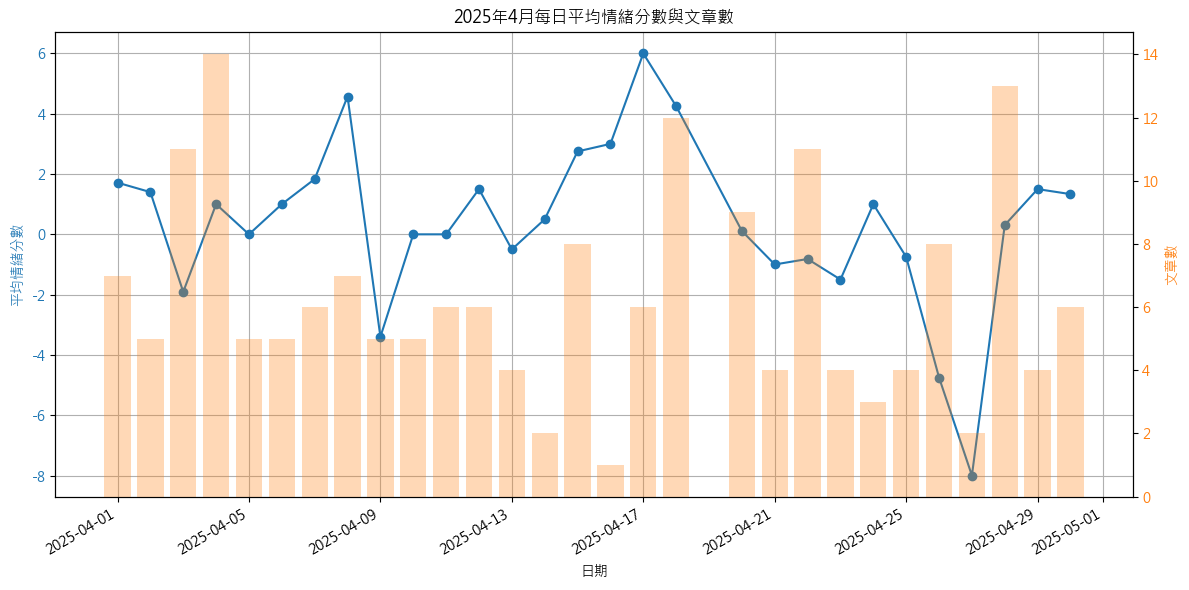

In [71]:
# 每日平均情緒
daily_score = april_df.groupby("artDate")["sentiment_value"].mean().reset_index()
# 合併每日文章數
april_post_counts = april_df.groupby(april_df['artDate'].dt.date).size().reset_index(name='post_count')
april_post_counts['artDate'] = pd.to_datetime(april_post_counts['artDate'])
daily_score = daily_score.merge(april_post_counts, on='artDate', how='left')

# 畫出每日平均情緒分數與文章數
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(daily_score["artDate"], daily_score["sentiment_value"], marker="o", color='tab:blue', label="平均情緒分數")
ax1.set_xlabel("日期")
ax1.set_ylabel("平均情緒分數", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("2025年4月每日平均情緒分數與文章數")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(daily_score["artDate"], daily_score["post_count"], alpha=0.3, color='tab:orange', label="文章數")
ax2.set_ylabel("文章數", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

這張圖呈現的是 2025 年 4 月每日的平均情緒分數（藍線）與文章數量（橘柱）。
可以觀察到，整個四月的情緒分數是動盪比較大的。


In [85]:
april_28_df = april_df[april_df['artDate'] == pd.to_datetime('2025-04-04')]
april_28_df.head(10)

,system_id,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_value,sentiment_class
649,1019,https://www.ptt.cc/bbs/Gossiping/M.1743733768....,Re:[問卦]南部人怎麼看美國爸爸要課32%關稅,2025-04-04,有個澎科大畢業的\n \n我們取假名暫稱他為家誠好了\n \n家誠是民進党粉\n \n非常死...,Gossiping,6.0,正向
650,1021,https://www.ptt.cc/bbs/Gossiping/M.1743741105....,[問卦]這時期對岸把ECFA全斷的話會怎樣?,2025-04-04,ECFA 被某群人稱為糖衣毒藥\n但是舔個不停\n\n\n以下來自CHAT GPT\n\n涵...,Gossiping,5.0,正向
651,1022,https://www.ptt.cc/bbs/Gossiping/M.1743744749....,[問卦]各國對chatgpt課徵關稅會怎樣,2025-04-04,現在全世界最流行的手遊\n\n就是chat gpt\n\n搞得宮崎駿要喊告\n\n又逢川普大...,Gossiping,1.0,正向
652,1023,https://www.ptt.cc/bbs/Gossiping/M.1743745412....,[問卦]〓.〓叫chatgpt做事不成還敢叫我訂閱,2025-04-04,openai真的是一間垃圾公司\n\n丟給他圖片叫他處理\n\n連基本的生物特徵都捕捉不了\...,Gossiping,-1.0,負向
653,1024,https://www.ptt.cc/bbs/Gossiping/M.1743745515....,Re:[問卦]各國對chatgpt課徵關稅會怎樣,2025-04-04,其實這個建議這幾天在各國被討論的很多\n\n美國的貨物貿易對全世界都是嚴重逆差的。\n\n但...,Gossiping,-1.0,負向
654,1028,https://www.ptt.cc/bbs/Gossiping/M.1743756394....,Re:[爆卦]Live川普對台開徵32%關稅行政院記者會,2025-04-04,"預算被藍白砍了, 怎麼還有手語師?\nhttps://imgur.com/OFNjmuB\n...",Gossiping,0.0,負向
655,1029,https://www.ptt.cc/bbs/Gossiping/M.1743757912....,[問卦]補貼算不算非關稅壁壘?,2025-04-04,川普說64%算法不是純關稅\n是包括非關稅壁壘跟匯率操縱\n\n那現在有個問題\n補貼算不算...,Gossiping,-1.0,負向
656,1030,https://www.ptt.cc/bbs/Gossiping/M.1743758104....,[問卦]不會治國幹嘛不問一下ChatGPT?,2025-04-04,台灣應對美國32%關稅的策略建議\n\n美國對台灣課徵32%關稅，這不只是經濟問題，更涉及國...,Gossiping,4.0,正向
657,1032,https://www.ptt.cc/bbs/Gossiping/M.1743760232....,Re:[問卦]不會治國幹嘛不問一下ChatGPT?,2025-04-04,讀完整個解答是認為：\n\n如果政府真的採納這些措施，說「不會完蛋」必定是假的，因為川普能臨...,Gossiping,1.0,正向
658,1033,https://www.ptt.cc/bbs/Gossiping/M.1743761639....,[問卦]台灣是沒有辦法還是不想面對？,2025-04-04,奇怪了\n\n台灣面對美國是完全一點辦法都沒有嗎？\n\n明明連ChatGPT都能洋洋灑灑的...,Gossiping,0.0,負向


而4/4的討論度很高，經過查詢可以發現多數人是在討論有關關稅政策的內容，但我們也可以發現其他和政治關聯性比較小的議題



像是4/18版上的討論也非常熱烈，主要的話題是圍繞在一篇在討論chatgpt和ptt的比較，也有許多篇回復的文章，那我們從鄉民的回應中可以看出，許多人認為使用 PTT 是為了觀看鄉民互相吐槽、幽默互動或是欣賞梗圖等娛樂性內容，偏向消遣用途，而非真的要從這些文中找到正確的知識；而 ChatGPT 則較常被用於獲得正經的建議、深度的對談、找到實用解答以及知識性內容。
雖然兩者的功能取向不同、難以直接比較，但這篇貼文與留言內容仍反映出一個重要現象：AI 工具正逐漸被人們視為能提供穩定回應與情緒支持的對話替代角色，甚至在某些情境中優於傳統網路互動。

In [61]:
# 先篩選 2025 年 4 月的文章
april_words = word_df[
    pd.to_datetime(word_df['artDate']).dt.year.eq(2025) &
    pd.to_datetime(word_df['artDate']).dt.month.eq(4)
]
# 讀取停用字詞
with open('dict/stop_words.txt', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f if line.strip())
    # 新增自訂停用字
    custom_stopwords = {'問題', '現在', 'ChatGPT', 'chatgpt', '真的', '直接', '知道', 'my', '八卦', '覺得', '需要', '一直', '有'}
    stopwords.update(custom_stopwords)
# 去除停用字
april_words = april_words[~april_words['word'].isin(stopwords)]

# 統計詞頻
words_427 = (
    april_words['word']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'word', 'count': 'count'})
)
words_427


,word,count
0,台灣,148
1,美國,90
2,AI,81
3,政府,65
4,關稅,56
...,...,...
6294,也將,1
6295,Chat,1
6296,語意,1
6297,可行,1


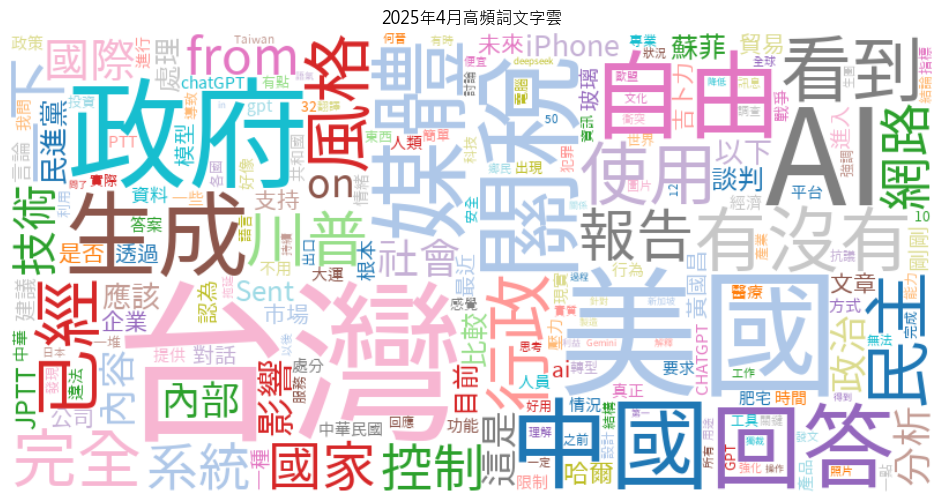

In [62]:
# 建立詞頻字典
word_freq = dict(zip(words_427['word'], words_427['count']))
font_path = 'TaipeiSansTCBeta-Regular.ttf'
# 畫出文字雲
wc = WordCloud(font_path=font_path, background_color="white", width=800, height=400, colormap='tab20').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('2025年4月高頻詞文字雲')
plt.show()


這張文字雲統計 2025 年 4 月所有 ChatGPT 貼文的關鍵詞。可以看到「美國」、「台灣」、「政府」、「關稅」、「媒體」等詞彙佔據主導。當時正值川普政府宣布新的關稅貿易政策，對全球造成了劇烈的動盪，也影響了科技業的生態，因此那段時間的討論主軸偏向 ChatGPT 的社會角色與國際科技政策，也不乏和「AI治理」、「政策管控」、「產業調整」有關的關鍵詞，情緒也因此較容易分歧與波動。當然我們也可以看到比較輕鬆的內容，如當時很紅的吉卜力也有出現在圖中

### 五. CKIP 標註

#### 5.1 將資料集用CKIP進行處理

In [86]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [87]:
data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=bf401258-207f-4804-8d75-2256f87c9e0e
To: c:\Users\1218a\OneDrive\桌面\大三\社群媒體分析\final\data.zip
100%|██████████| 1.88G/1.88G [03:03<00:00, 10.2MB/s]


In [88]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\1218a\AppData\Local\Programs\Python\Python311\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\1218a\AppData\Local\Programs\Python\Python311\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\1218a\AppData\Local\Programs\Python\Python311\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by

In [89]:
## 讀取文章
df = pd.read_csv('./raw_data/filtered_data.csv')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,2,https://www.ptt.cc/bbs/Gossiping/M.1704096724....,[問卦]這張新年賀圖大家喜歡嗎？,2024-01-01 16:12:00,twnndnpdnc,Gossiping,是這樣的\n最近用chat gpt 生產新年賀圖\nhttp://i.imgur.com/D...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""s820912gmail...",42.73.129.99,2024-01-02 01:33:08,ptt
1,3,https://www.ptt.cc/bbs/Gossiping/M.1704191333....,[問卦]還有人記得2023發生什麼事情嗎,2024-01-02 18:28:51,nk11208z,Gossiping,現在是2024了\n\n但是很多人似乎都忘記2023發生什麼事情了\n\n我還記得去年這時候...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""james732"", ""...",1.169.134.159,2024-01-03 01:35:40,ptt
2,5,https://www.ptt.cc/bbs/Gossiping/M.1704284689....,[問卦]貝佐斯酸ChatGPT?,2024-01-03 20:24:47,arsl400,Gossiping,最近貝佐斯上節目\n說ChatGPT是發現不是發明\n可是我剛剛去問ChatGPT\n它說自...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""bouedx"", ""cm...",219.91.32.112,2024-01-04 01:33:23,ptt


In [90]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [91]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list)
        # word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [92]:
pos_table, entity_table, sentence_table = get_nlp_result(df)
# time costing: 4841.512410879135

time costing: 962.8183555603027


In [93]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 1154
posts have NER: 912


In [94]:
# 將文章存成csv
pos_table.to_csv('raw_data/pos_table_chatgpt.csv', index = False)
entity_table.to_csv('raw_data/entity_table_chatgpt.csv', index = False)
sentence_table.to_csv('raw_data/sentence_table_chatgpt.csv', index = False)

#### 5.2 探索分析 - NER

In [95]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table_chatgpt.csv") 
entity_table = pd.read_csv("raw_data/entity_table_chatgpt.csv") 
sentence_table = pd.read_csv("raw_data/sentence_table_chatgpt.csv") 

In [96]:
entity_table['ner'].unique() #查看實體種類

array(['DATE', 'GPE', 'EVENT', 'PERSON', 'LANGUAGE', 'NORP', 'ORG',
       'CARDINAL', 'LOC', 'WORK_OF_ART', 'PRODUCT', 'TIME', 'ORDINAL',
       'FAC', 'MONEY', 'QUANTITY', 'LAW', 'PERCENT'], dtype=object)

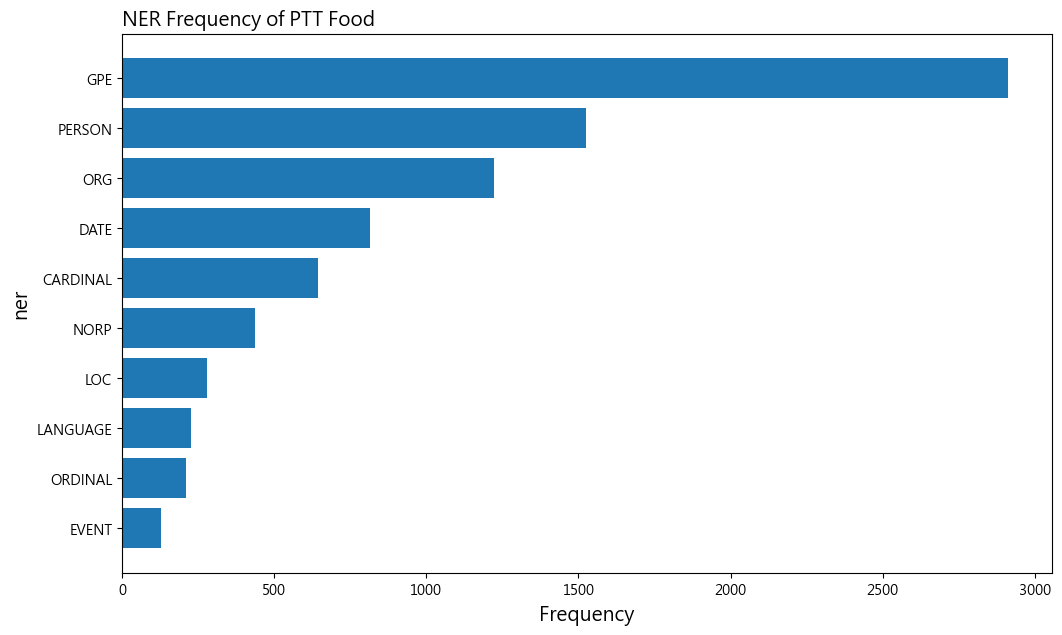

In [43]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
plt.show()

我們先用ckip標註出不同詞性的字詞分布
我們先看NER的部分


涉及到的民族、宗教、政治團體(NORP)

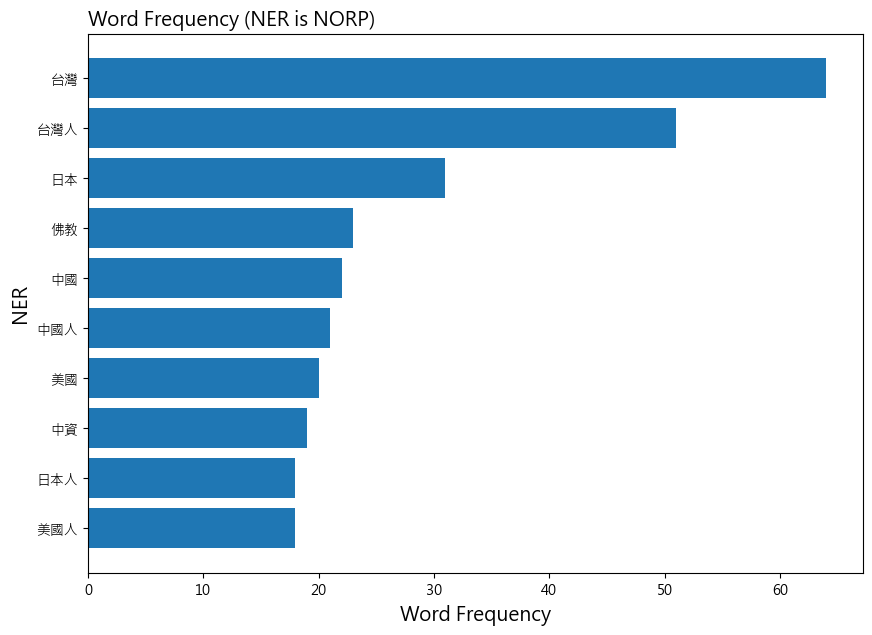

In [44]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
plt.show()

第一個是統計 ChatGPT 討論中出現頻率最高的「國族/民族」詞彙。
可以看到「台灣」、「美國」、「中國」的排名很靠前，
網友在討論AI話題時，常會參考不同國家的政策、態度或技術發展進度還有時事的部分，也有部份是在討論政治時，用AI生成的內容輔助自己的論點等等的。


可以看到版上的討論重點大多聚焦於「台灣」、「中國」、「美國」

涉及到的組織(ORG)

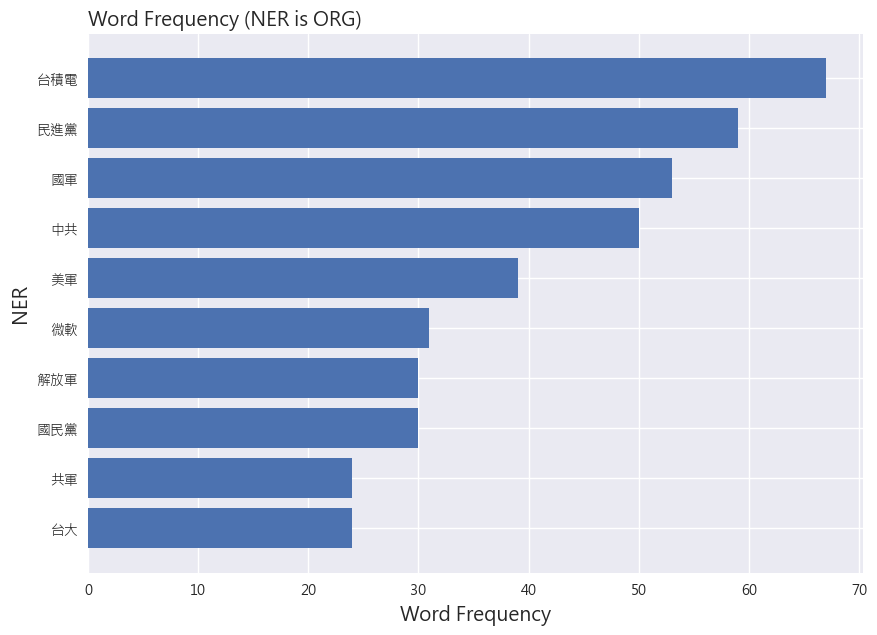

In [303]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
plt.show()

下面找出「台積電」相關文章，與後續情緒分析一起做探索

In [304]:
keyword_list = ['台積電']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

台積電：23篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,artMonth
50,80,https://www.ptt.cc/bbs/Gossiping/M.1708576449....,Re:[問卦]還有誰沒買ETF嗎？,2024-02-22,lpbrother,Gossiping,鄉民好，我股市白吃啦\n\n以前只知道股票是一間實體的公司或是工廠\n\n因為資金不足，\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Wolverin5566...",101.136.233.26,2024-02-23 01:31:20,ptt,2024-02
68,103,https://www.ptt.cc/bbs/Gossiping/M.1709525256....,Re:[問卦]台股一萬九千點是誰的功勞？,2024-03-04,ljsnonocat2,Gossiping,當然是OpenAI的功勞啊\n\n 當初2022年全世界股市因為美國通膨升息跌到爛掉\n\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""tamama000"", ...",124.155.144.122,2024-03-05 01:27:50,ptt,2024-03
73,109,https://www.ptt.cc/bbs/Gossiping/M.1709785030....,Re:[問卦]高雄台積電怎麼「蓋這麼慢」？,2024-03-07,wangrg,Gossiping,"我們把AI分為雲AI(類似ChatGPT),以及邊緣AI(類似波斯頓機器人)\n總共兩種\n...","[{""cmtStatus"": ""→"", ""cmtPoster"": ""devidevi"", ""...",122.116.188.181,2024-03-08 01:34:08,ptt,2024-03


In [84]:
keyword_list = ['微軟']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(10)

微軟：22篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
33,54,https://www.ptt.cc/bbs/Gossiping/M.1707821755....,[問卦]為什麼Meta股價創新高R,2024-02-13 18:55:53,Supasizeit,Gossiping,臉書沒人用了\n\nIG被TikTok 打趴\n\nVR沒人要買\n\n元宇宙是一場災難\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""E6300"", ""cmt...",203.204.195.174,2024-02-14 01:28:14,ptt
51,81,https://www.ptt.cc/bbs/Gossiping/M.1708579261....,[問卦]微軟的copilot跟智障沒兩樣？,2024-02-22 13:20:56,hugh509,Gossiping,微軟的copilot不是說是用GPT4\n為啥跟智障一樣？\n\n不會上下文，不會判斷語意，...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""koromo1991"",...",111.246.144.247,2024-02-23 01:31:44,ptt
63,96,https://www.ptt.cc/bbs/Gossiping/M.1709209105....,[問卦]花錢買的AI和自己送上門的AI哪個香,2024-02-29 20:18:23,IhateOGC,Gossiping,今天蛇蛇發現W11更新後突然被裝了AI搜尋\n\n原來我是天選之人天上突然掉下來的禮物\n\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""panex0845"", ...",118.231.129.65,2024-03-01 01:33:23,ptt
112,162,https://www.ptt.cc/bbs/Gossiping/M.1711895991....,[問卦]欸!中研院開發的大型語言模型現況?,2024-03-31 22:39:49,InvincibleK,Gossiping,"之前拿國家補助,\n\n用國家運算資源訓練,\n\n號稱用Hugging face公開程式碼...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""bonfferoni"",...",77.111.245.13,2024-04-01 01:53:12,ptt
118,172,https://www.ptt.cc/bbs/Gossiping/M.1712102062....,[問卦]賈伯斯看到ChatGPT會怎麼竊取？,2024-04-03 07:54:20,nissan168,Gossiping,https://youtu.be/a6jeZ7m0ycw?si=FwrGIKivh4et2L...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""slovea"", ""cm...",118.167.201.93,2024-04-05 01:21:14,ptt
147,210,https://www.ptt.cc/bbs/Gossiping/M.1714143342....,[問卦]微軟compilot好用嗎,2024-04-26 22:55:40,renna038766,Gossiping,就微軟最近出的chat gpt\nwindow上最近跑出來\nBing瀏覽器上也有\n\n聽...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""rwr"", ""cmtCo...",1.200.168.188,2024-04-27 01:39:21,ptt
148,211,https://www.ptt.cc/bbs/Gossiping/M.1714144344....,Re:[問卦]微軟compilot好用嗎,2024-04-26 23:12:22,xzcb2008,Gossiping,屌虐目前的=.=chatgpt\n\n阿肥說真的\n\n我已經轉往copilot 了\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""tmgl"", ""cmtC...",1.168.40.207,2024-04-27 01:39:28,ptt
156,227,https://www.ptt.cc/bbs/Gossiping/M.1715620730....,[問卦]ChatGPT4o,2024-05-14 01:18:48,Vanced,Gossiping,如題\n \n現在OpenAi正在發表春季更新\n \n新版gpt可以臨時被語音打斷 速度快...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Stella"", ""cm...",1.164.115.159,2024-05-14 01:39:31,ptt
182,255,https://www.ptt.cc/bbs/Gossiping/M.1716181353....,Re:[問卦]國台辦等等會怎麼森七七發稿?,2024-05-20 13:02:31,ljsnonocat2,Gossiping,剛問微軟的copilot 竟然被拒絕回答\n\n 但是ChatGPT卻可以給回答\nhtt...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""bill403777"",...",223.138.25.134,2024-05-21 01:33:35,ptt
192,269,https://www.ptt.cc/bbs/Gossiping/M.1716466985....,[問卦]有沒有Copilot掛掉的八卦?,2024-05-23 20:23:02,meowlike,Gossiping,重度使用copilot的朋友要忍一下了\n\n微軟說從下午四點開始掛了\n\n到現在都還沒修...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""OGC1000times...",114.136.162.241,2024-05-24 01:46:40,ptt


第二個是組織的部分。可以看到「台積電」、「微軟」等高頻出現。我們發現大部分講到「台積電」都是討論股市相關的文章，像是討論科技股未來的走勢，或是影響股市震盪的企業等等的。而提及「微軟」的，大部分是在比較chatgpt和微軟開發的大型語言模型copilot的優缺點

涉及到的人名(PERSON)

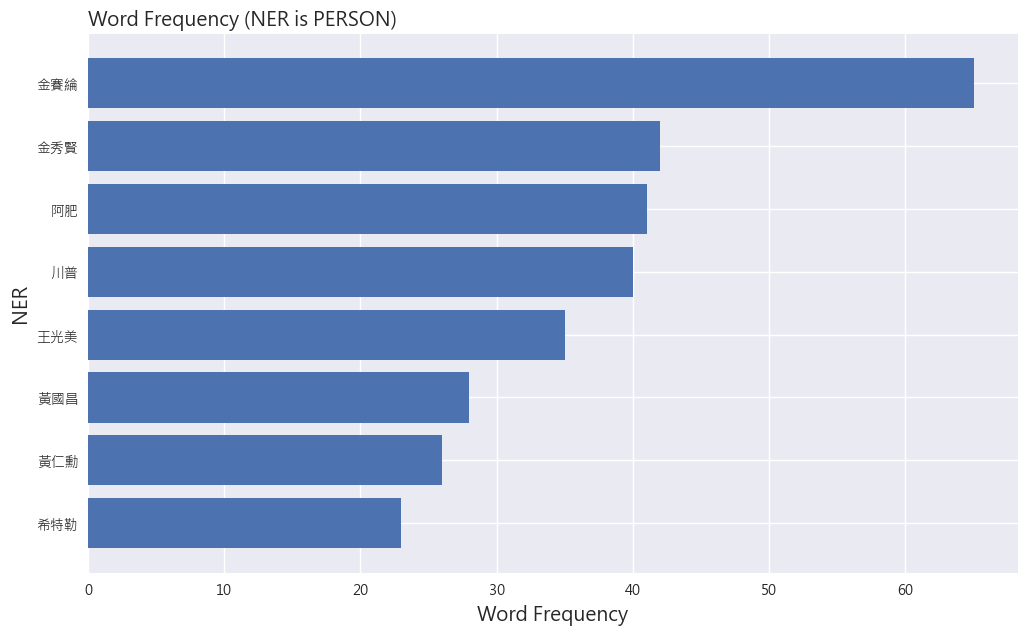

In [307]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
plt.show()

這張圖是 ChatGPT 討論中最常出現的人名，例如「川普」、「黃仁勳」等。這顯示多數的討論還是會和時事掛勾，並將政治人物或科技名人的發言、立場串連在一起等。

#### 5.3 探索分析 - POS

POS 種類分析

In [308]:
pos_table['pos'].unique()

array(['SHI', 'VH', 'DE', 'Nd', 'P', 'VC', 'Na', 'FW', 'VE', 'Nep', 'Nf',
       'Nh', 'VK', 'T', 'Ncd', 'Dfa', 'D', 'Cbb', 'Neqa', 'VJ', 'VL',
       'VF', 'COMMACATEGORY', 'VCL', 'Neu', 'Nc', 'VI', 'VA', 'Ng', 'Nb',
       'Nes', 'Di', 'VB', 'A', 'Caa', 'VG', 'Cab', 'VHC', 'Nv', 'Da',
       'VD', 'V_2', 'Dk', 'Cba', 'I', 'Dfb', 'Neqb', 'VAC',
       'PERIODCATEGORY', 'ETCCATEGORY', 'COLONCATEGORY',
       'PARENTHESISCATEGORY', 'DM', 'PAUSECATEGORY'], dtype=object)

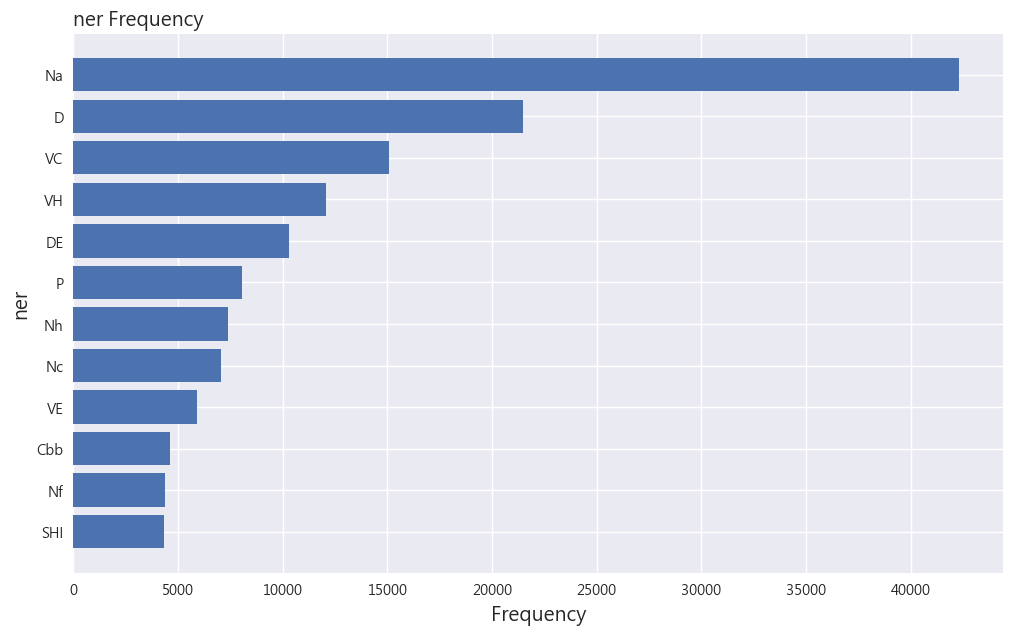

In [312]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
plt.show()

涉及到的名詞(Noun)

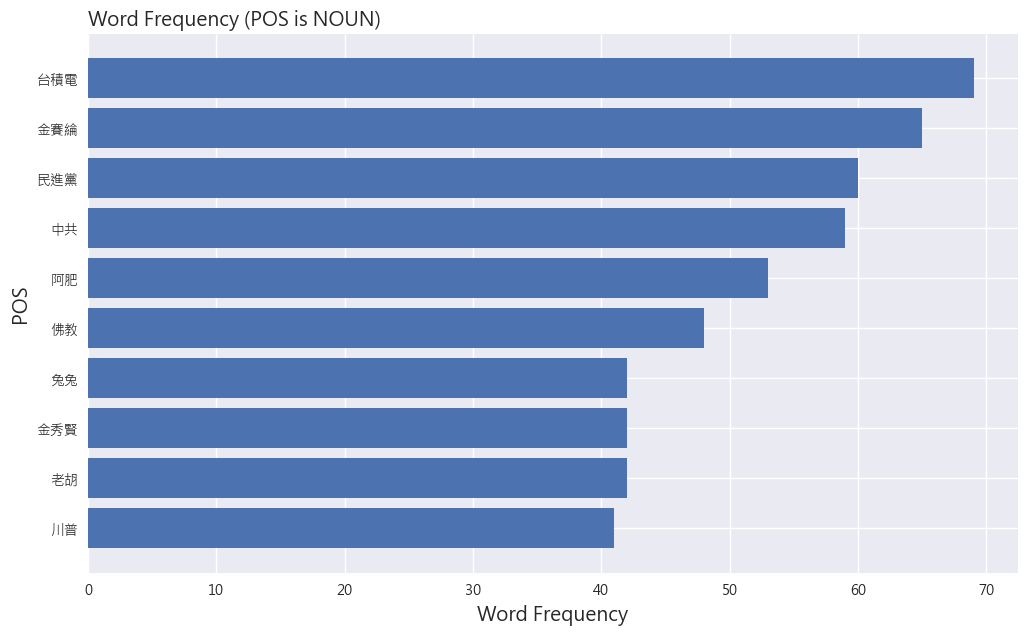

In [317]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
plt.show()

這張圖統計出現頻率最高的名詞，一樣出現了「台積電」、「川普」、「中共」。可以看出八卦版的使用者在討論 ChatGPT 時，時常將內容和時事掛勾，也足以顯示台積電對台灣人在科技方面的重要性

涉及到的動詞(VERB)

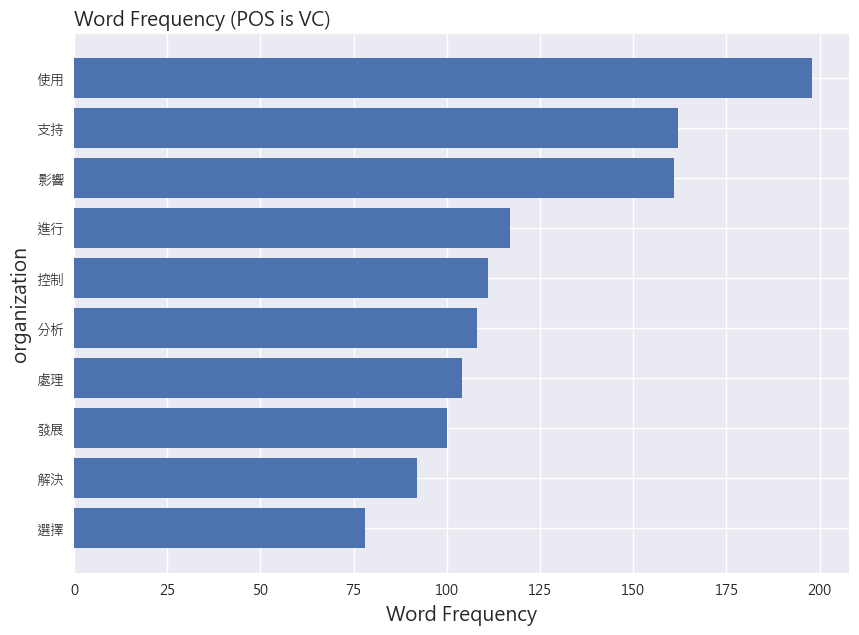

In [321]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
plt.show()

在動詞的統計中，我們可以發現在貼文中的動詞，「使用」佔了相當高的頻率，其他還有出現「分析」、「翻譯」、「學習」、「選擇」等詞彙，可看出大部分的人使用chatgpt的用途，以及chatgpt在使用者心中大概的定位。